In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path_to_data = "/content/drive/My Drive/eICU_Data"

In [ ]:
import tensorflow as tf

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
input_path = path_to_data + '/fold_0'
model_dir = path_to_data + '/fold_0'

In [ ]:
class SequenceExampleParser(object):
    def __init__(self, batch_size, num_map_threads=4):
        self.context_features_config = {
            'patientId': tf.io.VarLenFeature(tf.string),
            'label.readmission': tf.io.FixedLenFeature([1], tf.int64),
            'label.expired': tf.io.FixedLenFeature([1], tf.int64)
        }
        self.sequence_features_config = {
        'dx_ints': tf.io.VarLenFeature(tf.int64),
        'proc_ints': tf.io.VarLenFeature(tf.int64),
        'prior_indices': tf.io.VarLenFeature(tf.int64),
        'prior_values': tf.io.VarLenFeature(tf.float32)
        }
        self.batch_size = batch_size
        self.num_map_threads = num_map_threads
    def __call__(self, tfrecord_path, label_key, training):
        def parser_fn(serialized_example):
            (batch_context, batch_sequence) = tf.io.parse_single_sequence_example(
                serialized_example,
                context_features=self.context_features_config,
                sequence_features=self.sequence_features_config)
            labels = tf.squeeze(tf.cast(batch_context[label_key], tf.float32))
            return batch_context,batch_sequence, labels
        num_epochs = 1
        # num_epochs=1
        # buffer_size = self.batch_size * 32
        dataset = tf.data.TFRecordDataset(tfrecord_path)

        # dataset = dataset.shuffle(buffer_size)
        dataset = dataset.repeat(num_epochs)
        dataset = dataset.map(parser_fn, num_parallel_calls=self.num_map_threads)
        dataset = dataset.batch(self.batch_size)
        # dataset = dataset.prefetch(1)
        return dataset

In [ ]:
seq_samp= SequenceExampleParser(batch_size=32)

In [ ]:
label_key = 'label.readmission'

In [ ]:
train_dataset = seq_samp(input_path + '/train.tfrecord',label_key, True)
test_dataset = seq_samp(input_path + '/train.tfrecord',label_key, False)

In [ ]:
# adv_samples=test_dataset.take(10)

In [ ]:
# for c,f,l in adv_samples:
#     print(c)
#     print(f)
#     print(l)

In [ ]:
total_samples = 0
for c,f,l in train_dataset:
    total_samples += 1
print(total_samples)

1026


In [ ]:
class GraphConvolutionalTransformer(tf.keras.Model):
    def __init__(self,
               embedding_size=128,
               num_transformer_stack=3,
               num_feedforward=2,
               num_attention_heads=1,
               ffn_dropout=0.08,
               attention_normalizer='softmax',
               multihead_attention_aggregation='concat',
               directed_attention=False,
               use_inf_mask=True,
               use_prior=True,
               num_classes=1,
               **kwargs):
        super(GraphConvolutionalTransformer, self).__init__(**kwargs)
        self._hidden_size = embedding_size
        self._num_stack = num_transformer_stack
        self._num_classes=num_classes
        self._num_feedforward = num_feedforward
        self._num_heads = num_attention_heads
        self._ffn_dropout = ffn_dropout
        self._attention_normalizer = attention_normalizer
        self._multihead_aggregation = multihead_attention_aggregation
        self._directed_attention = directed_attention
        self._use_inf_mask = use_inf_mask
        self._use_prior = use_prior
        self.layer_norms = [tf.keras.layers.LayerNormalization(axis=2) for _ in range(num_transformer_stack)]

        self._layers = {}
        self._layers['Q'] = []
        self._layers['K'] = []
        self._layers['V'] = []
        self._layers['ffn'] = []
        self._layers['head_agg'] = []
        self._layers['dense']=tf.keras.layers.Dense(self._num_classes, activation=None)
        for i in range(self._num_stack):
            self._layers['Q'].append(
                tf.keras.layers.Dense(
                    self._hidden_size * self._num_heads, use_bias=False,name=f'query_dense_{i}'))
            self._layers['K'].append(
                tf.keras.layers.Dense(
                    self._hidden_size * self._num_heads, use_bias=False,name=f'K_dense_{i}'))
            self._layers['V'].append(
                tf.keras.layers.Dense(
                    self._hidden_size * self._num_heads, use_bias=False,name=f'V_dense_{i}'))
            if self._multihead_aggregation == 'concat':
                self._layers['head_agg'].append(
                tf.keras.layers.Dense(self._hidden_size, use_bias=False,name=f'head_agg_{i}'))
            self._layers['ffn'].append([])
            for _ in range(self._num_feedforward - 1):
                self._layers['ffn'][i].append(
                    tf.keras.layers.Dense(self._hidden_size, activation='relu',name=f'ffn_dense_{i}'))
            self._layers['ffn'][i].append(tf.keras.layers.Dense(self._hidden_size))

    def feedforward(self, features,stack_index,training=None):
        for i in range(self._num_feedforward):
            features=self._layers['ffn'][stack_index][i](features)
            if training:
                features = tf.nn.dropout(features, rate=self._ffn_dropout)
        return features

    def qk_op(self,
            features,
            stack_index,
            batch_size,
            num_codes,
            attention_mask,
            inf_mask=None,
            directed_mask=None):
        q=self._layers['Q'][stack_index](features)
        q = tf.reshape(q,
                   [batch_size, num_codes, self._hidden_size, self._num_heads])
        k = self._layers['K'][stack_index](features)
        k = tf.reshape(k,
                   [batch_size, num_codes, self._hidden_size, self._num_heads])
        q = tf.transpose(q, perm=[0, 3, 1, 2])
        k = tf.transpose(k, perm=[0, 3, 2, 1])
        pre_softmax = tf.matmul(q, k) / tf.sqrt(
            tf.cast(self._hidden_size, tf.float32))
        pre_softmax -= attention_mask[:, None, None, :]
        if inf_mask is not None:
            pre_softmax -= inf_mask[:, None, :, :]

        if directed_mask is not None:
            pre_softmax -= directed_mask

        if self._attention_normalizer == 'softmax':
            attention = tf.nn.softmax(pre_softmax, axis=3)
        else:
            attention = tf.nn.sigmoid(pre_softmax)
        return attention

    @tf.function
    def get_embeddings(self,features,max_num_codes):
        embedding_dict, mask_dict = feature_embedder.lookup(features, max_num_codes)
        keys = ['visit'] + feature_keys
        embeddings = tf.concat([embedding_dict[key] for key in keys], axis=1)
        masks = tf.concat([mask_dict[key] for key in keys], axis=1)
        guide, prior_guide = create_matrix_vdp(features, masks, gct_params["use_prior"],
                                                gct_params["use_inf_mask"],
                                                max_num_codes,
                                                prior_scalar)
        masks=masks[:, :, None]
        return embeddings,masks,guide,prior_guide
    @tf.function
    def call(self, features,masks,guide,prior_guide,training=None):
        batch_size = tf.shape(features)[0]
        num_codes = tf.shape(features)[1]
        mask_idx = tf.cast(tf.where(tf.equal(masks[:, :, 0], 0.)), tf.int32)
        mask_matrix = tf.fill([tf.shape(mask_idx)[0]], tf.float32.max)
        attention_mask = tf.scatter_nd(
        indices=mask_idx, updates=mask_matrix, shape=tf.shape(masks[:, :, 0]))
        inf_mask = None
        if self._use_inf_mask:
            guide_idx = tf.cast(tf.where(tf.equal(guide, 0.)), tf.int32)
            inf_matrix = tf.fill([tf.shape(guide_idx)[0]], tf.float32.max)
            inf_mask = tf.scatter_nd(
                indices=guide_idx, updates=inf_matrix, shape=tf.shape(guide))
        directed_mask = None
        if self._directed_attention:
            inf_matrix = tf.fill([num_codes, num_codes], tf.float32.max)
            inf_matrix = tf.matrix_set_diag(inf_matrix, tf.zeros(num_codes))
            directed_mask = tf.matrix_band_part(inf_matrix, -1, 0)[None, None, :, :]
        attention = None
        attentions = []
        for i, layer_norm in enumerate(self.layer_norms):
            features = masks * features

            if self._use_prior and i == 0:
                attention = tf.tile(prior_guide[:, None, :, :],
                                    [1, self._num_heads, 1, 1])
            else:
                attention = self.qk_op(features, i, batch_size, num_codes,
                                    attention_mask, inf_mask, directed_mask)
            attentions.append(attention)
            v = self._layers['V'][i](features)
            v = tf.reshape(
                v, [batch_size, num_codes, self._hidden_size, self._num_heads])
            v = tf.transpose(v, perm=[0, 3, 1, 2])
            # post_attention is (batch, num_heads, num_codes, hidden_size)
            post_attention = tf.matmul(attention, v)
            if self._num_heads == 1:
                post_attention = tf.squeeze(post_attention, axis=1)
            elif self._multihead_aggregation == 'concat':
                # post_attention is (batch, num_codes, num_heads, hidden_size)
                post_attention = tf.transpose(post_attention, perm=[0, 2, 1, 3])
                # post_attention is (batch, num_codes, num_heads*hidden_size)
                post_attention = tf.reshape(post_attention, [batch_size, num_codes, -1])
                # post attention is (batch, num_codes, hidden_size)
                post_attention = self._layers['head_agg'][i](post_attention)
            else:
                post_attention = tf.reduce_sum(post_attention, axis=1)
            post_attention += features
            post_attention = layer_norm(post_attention)
            post_ffn = self.feedforward(post_attention, i, training)
            post_ffn += post_attention
            post_ffn = layer_norm(post_ffn)
            features = post_ffn
        hidden=features * masks
        pre_logits=hidden[:,0,:]
        pre_logits=tf.reshape(pre_logits,[-1,self._hidden_size])
        logits=self._layers['dense'](pre_logits)
        logits=tf.squeeze(logits)
        return logits, attentions


In [ ]:
class FeatureEmbedder(object):
    def __init__(self, vocab_sizes, feature_keys, embedding_size):
        self._params = {}
        self._feature_keys = feature_keys
        self._vocab_sizes = vocab_sizes
        dummy_emb = tf.zeros([1, embedding_size], dtype=tf.float32)
        for feature_key in feature_keys:
            vocab_size = self._vocab_sizes[feature_key]
            emb = tf.Variable(
                initial_value=tf.random.normal([vocab_size, embedding_size]), dtype=tf.float32, name=feature_key)
            self._params[feature_key] = tf.concat([emb, dummy_emb], axis=0)
        self._params['visit'] = tf.Variable(
            initial_value=tf.random.normal([1, embedding_size]), dtype=tf.float32, name='visit')
    @tf.function
    def lookup(self, feature_map, max_num_codes):
        masks = {}
        embeddings = {}
        for key in self._feature_keys:
            if max_num_codes > 0:
                feature = tf.SparseTensor(
                    indices=feature_map[key].indices,
                    values=feature_map[key].values,
                    dense_shape=[
                        feature_map[key].dense_shape[0],
                        feature_map[key].dense_shape[1], max_num_codes
                    ])
            else:
                feature = feature_map[key]
            feature_ids = tf.sparse.to_dense(
                feature, default_value=self._vocab_sizes[key])
            feature_ids = tf.squeeze(feature_ids, axis=1)
            embeddings[key] = tf.nn.embedding_lookup(self._params[key], feature_ids)

            mask = tf.SparseTensor(
                indices=feature.indices,
                values=tf.ones(tf.shape(feature.values)),
                dense_shape=feature.dense_shape)
            masks[key] = tf.squeeze(tf.sparse.to_dense(mask), axis=1)
        batch_size = tf.shape(list(embeddings.values())[0])[0]
        embeddings['visit'] = tf.tile(self._params['visit'][None, :, :],
                                    [batch_size, 1, 1])

        masks['visit'] = tf.ones(batch_size)[:, None]
        # print("embeddings:")
        # print(embeddings)

        return embeddings, masks

In [ ]:
gct_params = {
    "embedding_size": 128,
    "num_transformer_stack": 3,
    "num_feedforward": 2,
    "num_attention_heads": 1,
    "ffn_dropout": 0.08,
    "attention_normalizer": "softmax",
    "multihead_attention_aggregation": "concat",
    "directed_attention": False,
    "use_inf_mask": True,
    "use_prior": True,
}
vocab_sizes={'dx_ints':3249, 'proc_ints':2210}
feature_keys=['dx_ints', 'proc_ints']
embedding_size = gct_params['embedding_size']
reg_coef=0.1
prior_scalar=0.5
learning_rate=0.022
max_num_codes=50
batch_size=32
feature_keys=['dx_ints', 'proc_ints']

model=GraphConvolutionalTransformer(**gct_params)
feature_embedder = FeatureEmbedder(
                vocab_sizes, feature_keys, embedding_size)

In [ ]:
def create_matrix_vdp(features, mask, use_prior, use_inf_mask, max_num_codes,
                    prior_scalar):
    dx_ids = features['dx_ints']
    proc_ids = features['proc_ints']

    batch_size = dx_ids.dense_shape[0]
    num_dx_ids = max_num_codes if use_prior else dx_ids.dense_shape[-1]
    num_proc_ids = max_num_codes if use_prior else proc_ids.dense_shape[-1]
    num_codes = 1 + num_dx_ids + num_proc_ids

    guide = None
    if use_inf_mask:
        row0 = tf.concat([
            tf.zeros([1, 1]),
            tf.ones([1, num_dx_ids]),
            tf.zeros([1, num_proc_ids])
        ],axis=1)

        row1 = tf.concat([
            tf.zeros([num_dx_ids, 1 + num_dx_ids]),
            tf.ones([num_dx_ids, num_proc_ids])
        ],axis=1)

        row2 = tf.zeros([num_proc_ids, num_codes])

        guide = tf.concat([row0, row1, row2], axis=0)
        guide = guide + tf.transpose(guide)
        guide = tf.tile(guide[None, :, :], [batch_size, 1, 1])
        guide = (
            guide * mask[:, :, None] * mask[:, None, :] +
            tf.eye(num_codes)[None, :, :])
    prior_guide = None
    if use_prior:
        prior_values = features['prior_values']
        prior_idx_values = prior_values.values

        prior_indices = features['prior_indices']
        prior_batch_idx = prior_indices.indices[:, 0][::2]
        prior_idx = tf.reshape(prior_indices.values, [-1, 2])
        prior_idx = tf.concat(
            [prior_batch_idx[:, None], prior_idx[:, :1], prior_idx[:, 1:]], axis=1)

        temp_idx = (
            prior_idx[:, 0] * 1000000 + prior_idx[:, 1] * 1000 + prior_idx[:, 2])
        sorted_idx = tf.argsort(temp_idx)
        prior_idx = tf.gather(prior_idx, sorted_idx)

        prior_idx_shape = [batch_size, max_num_codes * 2, max_num_codes * 2]
        sparse_prior = tf.SparseTensor(
            indices=prior_idx, values=prior_idx_values, dense_shape=prior_idx_shape)
        prior_guide = tf.sparse.to_dense(sparse_prior, validate_indices=True)

        visit_guide = tf.convert_to_tensor(
            [prior_scalar] * max_num_codes + [0.0] * max_num_codes * 1,
            dtype=tf.float32)
        prior_guide = tf.concat(
            [tf.tile(visit_guide[None, None, :], [batch_size, 1, 1]), prior_guide],
            axis=1)
        visit_guide = tf.concat([[0.0], visit_guide], axis=0)
        prior_guide = tf.concat(
            [tf.tile(visit_guide[None, :, None], [batch_size, 1, 1]), prior_guide],
            axis=2)
        prior_guide = (
            prior_guide * mask[:, :, None] * mask[:, None, :] +
            prior_scalar * tf.eye(num_codes)[None, :, :])
        degrees = tf.reduce_sum(prior_guide, axis=2)
        prior_guide = prior_guide / degrees[:, :, None]
    return guide,prior_guide


In [ ]:
def get_loss(logits, labels, attentions):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.reduce_mean(loss)

    if gct_params["use_prior"]:
        kl_terms = []
        attention_tensor = tf.convert_to_tensor(attentions)
        for i in range(1, gct_params["num_transformer_stack"]):
            log_p = tf.math.log(attention_tensor[i - 1] + 1e-12)
            log_q = tf.math.log(attention_tensor[i] + 1e-12)
            kl_term = attention_tensor[i - 1] * (log_p - log_q)
            kl_term = tf.reduce_sum(kl_term, axis=-1)
            kl_term = tf.reduce_mean(kl_term)
            kl_terms.append(kl_term)
        reg_term = tf.reduce_mean(kl_terms)
        loss += reg_coef * reg_term
    return loss

In [ ]:
def train_model(dataset, epochs=1):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    for epoch in range(epochs):
        # steps_per_epoch=100
        for step, (context,features, labels) in enumerate(dataset):
            if step>total_samples:
                break
            with tf.GradientTape() as tape:
                embeddings,masks,guide,prior_guide=model.get_embeddings(features,max_num_codes)
                logits, attentions = model(embeddings,masks,guide,prior_guide, training=True)
                loss= get_loss(logits, labels, attentions)
            gradients = tape.gradient(loss, model.trainable_variables)
            # print(gradients)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

In [ ]:
def evaluate_model(model, dataset):
    total_loss = 0
    # Initialize metrics here, e.g., accuracy
    num_batches = 0
    accuracy_metric = tf.keras.metrics.Accuracy()
    auc_pr = tf.keras.metrics.AUC(curve='PR', summation_method='interpolation')

    # feature_embedder = FeatureEmbedder(self._vocab_sizes, self._feature_keys, self._embedding_size)
    acc=0
    for context,features, labels in dataset:
        embeddings,masks,guide,prior_guide=model.get_embeddings(features,max_num_codes)
        logits, attentions = model(embeddings,masks,guide,prior_guide, training=False)
        loss = get_loss(logits, labels, attentions)
        probs=tf.nn.sigmoid(logits)
        predicted_classes = tf.cast(tf.greater_equal(probs, 0.4), tf.int32)
        labels_casted = tf.cast(labels, tf.int32)
        accuracy_metric.update_state(labels_casted, predicted_classes)
        # acc+=accuracy_metric.result().numpy
        batch_accuracy_metric = tf.keras.metrics.Accuracy()
        batch_accuracy_metric.update_state(labels_casted, predicted_classes)
        batch_auc=tf.keras.metrics.AUC(curve='PR', summation_method='interpolation')
        batch_auc.update_state(labels_casted, probs)
        auc_pr.update_state(labels_casted, probs)
        print("Batch accuracy:", batch_accuracy_metric.result().numpy())
        print("Batch AUC:", batch_auc.result().numpy())
        total_loss += loss.numpy()
        num_batches += 1

    avg_loss = total_loss / num_batches
    # avg_accuracy = acc/num_batches
    avg_accuracy = accuracy_metric.result().numpy()
    avg_auc=auc_pr.result().numpy()
    print(f"Eval Loss: {avg_loss}, Eval Accuracy: {avg_accuracy}, Eval AUC: {avg_auc}")
    # return avg_accuracy

In [ ]:
train_model(train_dataset, epochs=2)

Epoch 0, Loss: 0.4389280080795288
Epoch 1, Loss: 0.4266732633113861


In [ ]:
avg_accuracy = evaluate_model(model, test_dataset)

Batch accuracy: 1.0
Batch AUC: 0.0
Batch accuracy: 0.96875
Batch AUC: 0.2
Batch accuracy: 0.96875
Batch AUC: 0.027172027
Batch accuracy: 0.9375
Batch AUC: 0.04720752
Batch accuracy: 0.96875
Batch AUC: 0.02510489
Batch accuracy: 0.96875
Batch AUC: 0.02360376
Batch accuracy: 0.96875
Batch AUC: 0.2
Batch accuracy: 0.96875
Batch AUC: 0.024305224
Batch accuracy: 1.0
Batch AUC: 0.0
Batch accuracy: 0.9375
Batch AUC: 0.12732707
Batch accuracy: 1.0
Batch AUC: 0.0
Batch accuracy: 0.9375
Batch AUC: 0.054344054
Batch accuracy: 1.0
Batch AUC: 0.0
Batch accuracy: 0.96875
Batch AUC: 0.024305224
Batch accuracy: 1.0
Batch AUC: 0.0
Batch accuracy: 1.0
Batch AUC: 0.0
Batch accuracy: 0.9375
Batch AUC: 0.0520776
Batch accuracy: 0.9375
Batch AUC: 0.1465285
Batch accuracy: 0.96875
Batch AUC: 0.16666667
Batch accuracy: 0.96875
Batch AUC: 0.0260388
Batch accuracy: 1.0
Batch AUC: 0.0
Batch accuracy: 0.9375
Batch AUC: 0.12732707
Batch accuracy: 0.96875
Batch AUC: 0.02510489
Batch accuracy: 0.84375
Batch AUC: 0.2

In [ ]:
num_of_advsamples=30 #10 batches of test data samples

In [ ]:
adv_samples=test_dataset.take(num_of_advsamples)

In [ ]:
for c,f,l in adv_samples:
    for key,values in f.items():
        print(key,values)
    break

dx_ints SparseTensor(indices=tf.Tensor(
[[ 0  0  0]
 [ 0  0  1]
 [ 0  0  2]
 [ 0  0  3]
 [ 0  0  4]
 [ 0  0  5]
 [ 1  0  0]
 [ 1  0  1]
 [ 1  0  2]
 [ 1  0  3]
 [ 1  0  4]
 [ 1  0  5]
 [ 1  0  6]
 [ 1  0  7]
 [ 2  0  0]
 [ 2  0  1]
 [ 2  0  2]
 [ 2  0  3]
 [ 2  0  4]
 [ 2  0  5]
 [ 3  0  0]
 [ 3  0  1]
 [ 3  0  2]
 [ 3  0  3]
 [ 4  0  0]
 [ 4  0  1]
 [ 4  0  2]
 [ 4  0  3]
 [ 4  0  4]
 [ 4  0  5]
 [ 5  0  0]
 [ 5  0  1]
 [ 5  0  2]
 [ 5  0  3]
 [ 5  0  4]
 [ 6  0  0]
 [ 6  0  1]
 [ 6  0  2]
 [ 6  0  3]
 [ 7  0  0]
 [ 7  0  1]
 [ 7  0  2]
 [ 7  0  3]
 [ 7  0  4]
 [ 7  0  5]
 [ 8  0  0]
 [ 8  0  1]
 [ 8  0  2]
 [ 8  0  3]
 [ 8  0  4]
 [ 8  0  5]
 [ 8  0  6]
 [ 8  0  7]
 [ 8  0  8]
 [ 8  0  9]
 [ 9  0  0]
 [ 9  0  1]
 [ 9  0  2]
 [ 9  0  3]
 [ 9  0  4]
 [ 9  0  5]
 [ 9  0  6]
 [ 9  0  7]
 [ 9  0  8]
 [10  0  0]
 [10  0  1]
 [10  0  2]
 [10  0  3]
 [10  0  4]
 [10  0  5]
 [11  0  0]
 [11  0  1]
 [11  0  2]
 [11  0  3]
 [11  0  4]
 [11  0  5]
 [11  0  6]
 [12  0  0]
 [12  0  1]
 [12  0  2]


In [ ]:
def fgsm_attack(dataset, epochs=1):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.022)
    num_batches = 0
    total_loss = 0
    accuracy_metric = tf.keras.metrics.Accuracy()
    auc_pr = tf.keras.metrics.AUC(curve='PR', summation_method='interpolation')
    for epoch in range(epochs):
        epsilon = 0.002
        for step, (context,features, labels) in enumerate(dataset):
            with tf.GradientTape() as tape:
                tape.watch(features)
                embeddings,masks,guide,prior_guide=model.get_embeddings(features,max_num_codes)
                logits, attentions = model(embeddings, masks, guide, prior_guide, training=False)
                loss= get_loss(logits, labels, attentions)
            batch_size, dynamic_second_dim, embedding_size = embeddings.shape
            gradients = tape.gradient(loss, logits)
            perturbation = epsilon * tf.sign(gradients)

            perturbations_expanded = tf.expand_dims(tf.expand_dims(perturbation, -1), -1)

            # Tile the expanded 'perturbations' to fill up to the shape of 'embeddings'
            perturbations_tiled = tf.tile(perturbations_expanded, [1, dynamic_second_dim, embedding_size])

            # Apply the perturbations to the embeddings
            adversarial_embeddings = embeddings + perturbations_tiled


            advlogits, attentions = model(adversarial_embeddings,masks,guide,prior_guide, training=False)
            advloss = get_loss(logits, labels, attentions)
            probs=tf.nn.sigmoid(advlogits)
            predicted_classes = tf.cast(tf.greater_equal(probs, 0.5), tf.int32)
            labels_casted = tf.cast(labels, tf.int32)
            accuracy_metric.update_state(labels_casted, predicted_classes)
            # acc+=accuracy_metric.result().numpy
            batch_accuracy_metric = tf.keras.metrics.Accuracy()
            batch_accuracy_metric.update_state(labels_casted, predicted_classes)
            batch_auc=tf.keras.metrics.AUC(curve='PR', summation_method='interpolation')
            batch_auc.update_state(labels_casted, probs)
            auc_pr.update_state(labels_casted, probs)
            print("Adversarial Batch accuracy:", batch_accuracy_metric.result().numpy())
            print("Adversarial Batch AUC:", batch_auc.result().numpy())
            total_loss += advloss.numpy()
            num_batches += 1
        avg_loss = total_loss / num_batches
    # avg_accuracy = acc/num_batches
        avg_accuracy = accuracy_metric.result().numpy()
        avg_auc=auc_pr.result().numpy()
        print(f"Eval Loss: {avg_loss}, Eval Accuracy: {avg_accuracy}, Eval AUC: {avg_auc}")

            # fgsm_examples = features + epsilon * tf.sign(gradients)
            # print(gradients)
            # optimizer.apply_gradients(zip(gradients, features))

In [ ]:
adversarial_data =fgsm_attack(adv_samples, epochs=1)

Adversarial Batch accuracy: 1.0
Adversarial Batch AUC: 0.0
Adversarial Batch accuracy: 0.96875
Adversarial Batch AUC: 0.2
Adversarial Batch accuracy: 0.96875
Adversarial Batch AUC: 0.027172027
Adversarial Batch accuracy: 0.9375
Adversarial Batch AUC: 0.04720752
Adversarial Batch accuracy: 0.96875
Adversarial Batch AUC: 0.02510489
Adversarial Batch accuracy: 0.96875
Adversarial Batch AUC: 0.02360376
Adversarial Batch accuracy: 0.96875
Adversarial Batch AUC: 0.2
Adversarial Batch accuracy: 0.96875
Adversarial Batch AUC: 0.024305224
Adversarial Batch accuracy: 1.0
Adversarial Batch AUC: 0.0
Adversarial Batch accuracy: 0.9375
Adversarial Batch AUC: 0.12732707
Adversarial Batch accuracy: 1.0
Adversarial Batch AUC: 0.0
Adversarial Batch accuracy: 0.9375
Adversarial Batch AUC: 0.054344054
Adversarial Batch accuracy: 1.0
Adversarial Batch AUC: 0.0
Adversarial Batch accuracy: 0.96875
Adversarial Batch AUC: 0.024305224
Adversarial Batch accuracy: 1.0
Adversarial Batch AUC: 0.0
Adversarial Batch 

In [ ]:
def fgsm_attack(self,model, feature_embedder, features, labels, epsilon=0.01):
    # Convert features to embeddings
        # original_embeddings, _ = feature_embedder.lookup(features, self._max_num_codes)

        with tf.GradientTape() as tape:
            tape.watch(features)
            logits, attentions = self.get_prediction(model, feature_embedder, features, training=False)
            loss = self.get_loss(logits, labels,attentions)

        # Calculate gradients of loss with respect to embeddings
        gradients = tape.gradient(loss, features)

        # FGSM attack: Add sign of gradients to the embeddings
        perturbed_features = {k: v + epsilon * tf.sign(gradients[k]) for k, v in features.items()}

        return perturbed_features

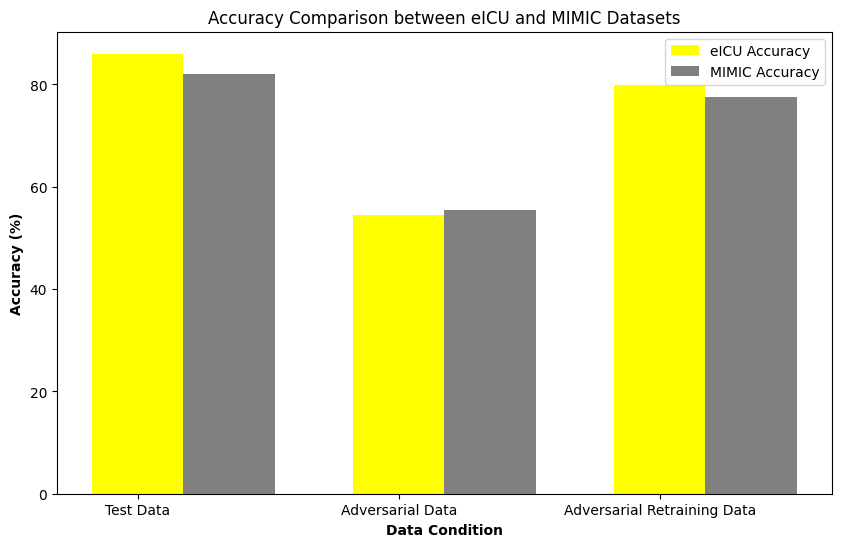

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Data
fig, ax = plt.subplots(figsize=(10, 6))

# Data
models = ['Test Data', 'Adversarial Data', 'Adversarial Training Data']
accuracy_eICU = [test_data_eicu, adv_data_eicu,adv_train_eicu]
accuracy_MIMIC = [test_data_mimic, adv_data_mimic,adv_train_mimic]

# Assigning bar positions
barWidth = 0.35
r1 = np.arange(len(accuracy_eICU))
r2 = [x + barWidth for x in r1]

# Plotting accuracy for eICU
ax.bar(r1, accuracy_eICU, color='yellow', width=barWidth, label='eICU Accuracy')

# Plotting accuracy for MIMIC
ax.bar(r2, accuracy_MIMIC, color='grey', width=barWidth, label='MIMIC Accuracy')

# Adding labels and title
ax.set_xlabel('Data Condition', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_xticks([r + barWidth / 2 - 0.175 for r in range(len(accuracy_eICU))])
ax.set_xticklabels(models)
ax.set_title('Accuracy Comparison between eICU and MIMIC Datasets')

# Creating legend & Show graphic
ax.legend()

# Show the plot
plt.show()
# Recreating the plots for the eICU and MIMIC dataset accuracy
# Setting up the figure and axes
